In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd

import pandas as pd

# Import SQLAlchemy `automap` and other dependencies here
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
 

In [4]:
from config import connection_string

engine = create_engine(connection_string)
connection = engine.connect()


### Inspect engine for table names

In [5]:
# get the table names from the engine.
inspector = inspect(engine)
inspector.get_table_names()

['title', 'employee', 'dept_emp', 'department', 'dept_manager', 'salary']

### Reflect Database into ORM classes

In [6]:
# build the relationships from the database
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['title', 'employee', 'department', 'salary']

### Establish a communication session with the engine

In [8]:
session = Session(bind=engine)

### Map Employee, Title, Salary class

In [13]:
Employee = Base.classes.employee
Salary = Base.classes.salary
Title = Base.classes.title

### Join Employee, Title, Salary tables and get salary averages by title

In [53]:

# join Employee, title, salary table, calculate average salary group by titles and convert them to data frame.
results =  pd.read_sql(session.query(Title.title, func.avg(Salary.salary).label('average'))\
                    .join(Employee, Employee.emp_title_id == Title.title_id)\
                    .join(Salary, Salary.emp_no == Employee.emp_no).group_by(Title.title).statement, engine)

# dynamically build colors for each title
colors = []
i = 1

# reference :- https://matplotlib.org/3.3.2/tutorials/colors/colors.html
overlap = {name for name in mcd.CSS4_COLORS
           if "xkcd:" + name in mcd.XKCD_COLORS}

for j, n in enumerate(sorted(overlap, reverse=True)):
    cn = mcd.CSS4_COLORS[n]
    colors.append(cn)
    # stop if the colors are picked for the titles in results
    if (i >= results['title'].count()):
        break;
    else:
       i += 1

# add colors to each title
results["Color"] = colors

#Set Index to title - ONLY RUN ONCE
results = results.set_index("title")


### Bar Graph Average Salary By Title

<ipython-input-58-906b1eaeb74a>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels, fontsize=20)


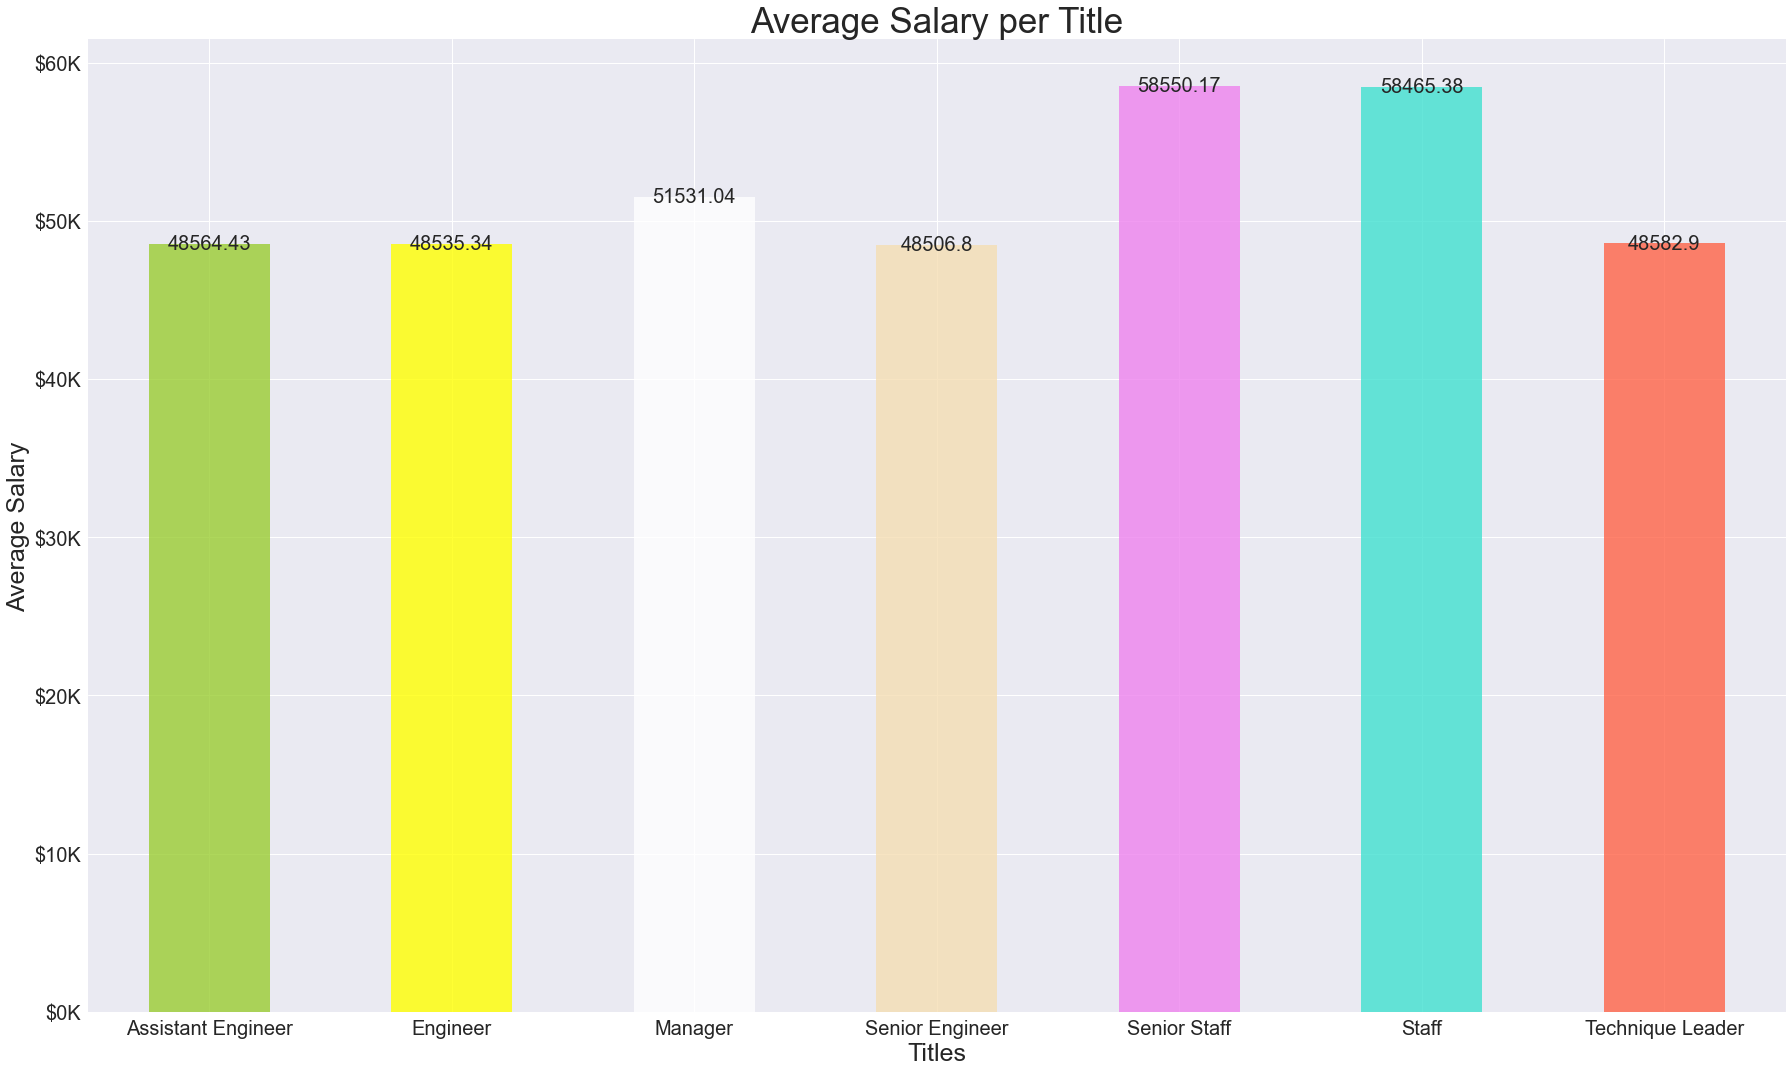

In [58]:

# build bar chart for the avaerage salary
plt.figure(figsize=(25,15))
# plot the bar chart
ax = results["average"].plot(kind="bar", color=results["Color"], alpha=.8,align="center",rot=0)

# plot y label ticks and xlabel ticks

ylabels = ['${:,.0f}'.format(x/1000.0) + 'K' for x in ax.get_yticks()]
ax.set_yticklabels(ylabels, fontsize=20)
plt.xticks(fontsize=20)
# add values to bar charts
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    # The width of the bar is the data value and can used as the label
    label_text = f"{round(height,2)}"  # f'{height:.2f}' if you have decimal values as labels
    label_x = x + width / 2
    label_y = y + height + 1
    ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=20)

# add xlabel, ylabel, title
plt.xlabel("Titles",fontsize=25)
plt.ylabel("Average Salary",fontsize=25)
plt.title("Average Salary per Title", fontsize=35)

plt.tight_layout()
plt.show()
